<div style="background-color: #ccffcc; padding: 10px;">
    <h1> Tutorial 5 </h1> 
    <h2> Introduction to Generative Adversarial Networks </h2>
</div>      


# Overview

This Jupyter notebook will walk you through building a simple GAN model and training it on the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) using [PyTorch](https://pytorch.org/). PyTorch is a very powerful library written in Python and C++ that facilitates the building and training of neural networks.

This tutorial is in 2 parts.

Part 1 was adapted from Caitlin Howarth's Presentation and tutorial as part of the LIFD Work shop series. Some of the code and explanations from this tutorial came from [Aleksa Gordić's pyctorch-gans repository](https://github.com/gordicaleksa/pytorch-gans). It contains some more in-depth explanations, as well as examples of more advanced GAN models than we covered here.

Part 2 is an applied Earth Science example

<hr>


<div style="background-color: #e6ccff; padding: 10px;">
    
<h1> Machine Learning Theory </h1>
    
Two networks, a generator and a discriminator.

Both networks are equally bad at their respective tasks initially.

As training continues, both networks compete with one another to get better at their respective tasks.

Eventually, the generator becomes so good that humans can’t tell the difference (hopefully!)
    
The Generator

The generator takes a latent code as an input, and then decodes that vector into an output.

Different latent codes should result in different outputs.

In the original implementation of GANs, the generator never actually sees the training dataset, and is solely guided by the discriminator. 

By contrast, the discriminator is just a simple regression network.

Outputs a score from 0 (fake) to 1 (real).

Values closer to 0 or 1 represent increased certainty that a sample is fake or real respectively.
    
    Loss Functions

Adversarial loss is essentially a minimax game, as proposed by Ian Goodfellow et al. [1]

The discriminator attempts to maximise the likelihood of correctly predicting real samples as real, and fake samples as fake.

The generator attempts to maximise the likelihood of the discriminator predicting that the fake samples it generates are real.

The discriminator loss is defined as: , where  is the discriminator,  is the generator,  is a sample from the real distribution and  is a latent vector given to the generator.

The generator loss is defined as: , where  is the discriminator,  is the generator, and  is a latent vector given to the generator.
</div>    
  

<div style="background-color: #cce5ff; padding: 10px;">

<h1> Python </h1>

Basic python knowledge is assumed for this tutorial. For this tutorial the main machine learning library we'll be working [PyTorch](https://pytorch.org/). Python specific information will be colour coded blue.
 
    
## PyTorch
    

</div>
    
<hr>



<div style="background-color: #ffffcc; padding: 10px;">
    
<h1> Requirements </h1>

These notebooks should run 

<h2> Python Packages: </h2>

* Python 3
* PyTorch
* time
* os
* numpy
* matplotlib=3.0 


<h2> Data Requirements</h2>

This notebook referes to some data included in the git hub repositroy
    
</div>

**Contents:**

1. [Download MNIST Dataset](#Download-MNIST-Dataset)
2. [Building the GAN](#Building-the-GAN)
3. [Preparing to train](#Preparing-to-train)
4. [Training](#Training)
5. [Evaluating the GAN](#Evaluating-the-GAN)
6. [Example Application to Earth Sciences](Example-Application-to-Earth-Sciences) 

<div style="background-color: #cce5ff; padding: 10px;">

**Import python modules**

</div>

In [3]:
# import modules
# general file system utilites
import os
import time
# Plotting and standard numpy
import numpy as np
from matplotlib import pyplot as plt
# Machine Learning Library PyTorch and specific tools
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.utils import make_grid, save_image

<div style="background-color: #cce5ff; padding: 10px;">

Check if GPU's available. This code will run on standard CPU's too just a bit slower    

</div>

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(device))
else:
  print("Warning No GPU available. Run Times may be slow")

Warning No GPU available. Run Times may be slow


<div style="background-color: #cce5ff; padding: 10px;">
Create data and image dir
</div>

In [6]:
dataset_path = os.path.join(os.getcwd(), "data")
image_path = os.path.join(os.getcwd(), "images")

# Ensure both of the directories are created.
if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

if not os.path.exists(image_path):
    os.mkdir(image_path)

# Download MNIST Dataset

<div style="background-color: #cce5ff; padding: 10px;">
With the file storage out of the way, we can define a few variables. Firstly, we need to set our batch size.
</div>

In [7]:
batch_size = 128

<div style="background-color: #ccffcc; padding: 10px;">

Next let's create a transform that normalises the pixels in our image to be within the range of -1 to 1. This helps the neural network to train better than leaving the inputs unnormalised.
    
</div>

In [8]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((.5,), (.5,))])

<div style="background-color: #ccffcc; padding: 10px;">
    
We can now load our data. As mentioned above, we're using the MNIST dataset. It's a very simple dataset of 28x28 greyscale images containing handwritten digits from 0 to 9. It has been used as a benchmark since the early days of machine learning, and is simple enough that we can train a GAN on it quite quickly, despite consisting of around 60,000 samples!

</div>

<div style="background-color: #cce5ff; padding: 10px;">
PyTorch contains the MNIST dataset as a baseline, so we can just use their preformed dataset to download the data.
</div>

In [9]:
mnist_dataset = datasets.MNIST(root=os.path.join(os.getcwd(), "data"), 
                               train=True, download=True, transform=transform)

0it [00:00, ?it/s]

Extracting /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw/train-images-idx3-ubyte.gz to /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw


0it [00:00, ?it/s]

Extracting /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw/train-labels-idx1-ubyte.gz to /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw


0it [00:00, ?it/s]

Extracting /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw


0it [00:00, ?it/s]

Extracting /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /nfs/earcemac/earhbu/LIFD/LIFD_ENV_ML_NOTEBOOKS/GenerativeAdversarialNetworks/data/MNIST/raw
Processing...
Done!


<div style="background-color: #cce5ff; padding: 10px;">
PyTorch uses a DataLoader wrapper around a dataset in order to iterate through the dataset. It's where we specify the number of samples per batch, as well as whether to shuffle the data. drop_last ensures that any batch that isn't at least 128 samples gets dropped.
</div>

In [10]:
mnist_data_loader = DataLoader(mnist_dataset, batch_size=batch_size, 
                               shuffle=True, drop_last=True)

<div style="background-color: #ccffcc; padding: 10px;">
Let's confirm how many image samples we have, as well as get a sample of images to show.
<div>

Dataset size: 60000 images.


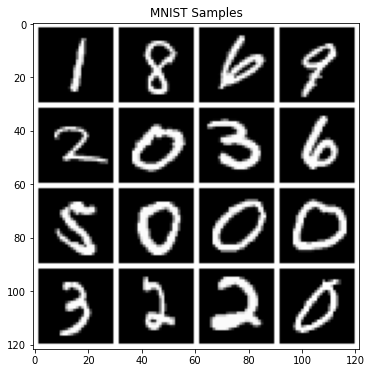

In [11]:
print(f'Dataset size: {len(mnist_dataset)} images.')

# Get a batch from the dataloader and take 16 images from that batch to display.
batch = next(iter(mnist_data_loader))
img_batch = batch[0]
img_batch_subset = img_batch[:16]  # extract only a subset of images

# Form a grid of images and display them.
grid = make_grid(img_batch_subset, nrow=int(4), normalize=True, pad_value=1.)

# Rearrange axis from channels first to channels last for MatPlotLib.
grid = np.moveaxis(grid.numpy(), 0, 2)

# Plot our figure.
plt.figure(figsize=(6, 6))
plt.title("MNIST Samples")
plt.imshow(grid)
plt.show()

<div style="background-color: #ccffcc; padding: 10px;">

Now we have seen our data, we can start building our neural network!
</div>

# Building the GAN

<div style="background-color: #ccffcc; padding: 10px;">
Recall that the generator has a latent space from which we draw samples from by input random vectors. Let's define it as a vector with 100 elements and create a function to generate a batch of latent inputs.
</div>

In [12]:
LATENT_SPACE_DIM = 100

def get_gaussian_latent_batch(batch_size, device):
    return torch.randn((batch_size, LATENT_SPACE_DIM), device=device)



<div style="background-color: #e6ccff; padding: 10px;">
        
We can now start constructing our neural networks. Remember that generative adversarial networks are actually composed of two networks: a generator and a discriminator.

    
Let's create a building block for constructing the networks first:
</div>

In [13]:
def network_block(in_feat, out_feat, normalize=True, activation=None):
    layers = [nn.Linear(in_feat, out_feat)]
    if normalize:
        layers.append(nn.BatchNorm1d(out_feat))

    layers.append(nn.LeakyReLU(0.2) if activation is None else activation)

    return layers


<div style="background-color: #e6ccff; padding: 10px;">
    
This building block consists of a Linear (or fully connected) layer, a batch normalisation layer and an activation function layer (Leaky ReLU).

</div>    
<div style="background-color: #ccffcc; padding: 10px;">
Using this block, let's now build our generator, which is tasked with creating new MNIST samples:
</div>

In [14]:
class GeneratorNet(torch.nn.Module):
    def __init__(self, img_shape=(28, 28)):
        super().__init__()
        self.generated_img_shape = img_shape
        num_neurons_per_layer = [LATENT_SPACE_DIM, 256, 512, 1024, img_shape[0] * img_shape[1]]

        # Let's define our network as a series of four of the blocks we defined above. Each time we increase the
        # number of neurons per layer and use the leaky ReLU as our activation function. For the last set of layers,
        # we skip normalisation and instead apply a hyperbolic tangent as our activation layer. This is so that the
        # output of the network is in the range of -1 to 1, with the same number of pixels as the inputs.
        self.net = nn.Sequential(
            *network_block(num_neurons_per_layer[0], num_neurons_per_layer[1]),
            *network_block(num_neurons_per_layer[1], num_neurons_per_layer[2]),
            *network_block(num_neurons_per_layer[2], num_neurons_per_layer[3]),
            *network_block(num_neurons_per_layer[3], num_neurons_per_layer[4], normalize=False, activation=nn.Tanh())
        )

    def forward(self, latent_vector_batch):
        img_batch_flattened = self.net(latent_vector_batch)

        # The output of the network is a vector of 784 pixels, let's reshape it so it's a matrix of 28x28 pixels.
        return img_batch_flattened.view(img_batch_flattened.shape[0], 1, *self.generated_img_shape)


<div style="background-color: #e6ccff; padding: 10px;">
    
The above generator is built using four of the network blocks we defined above, each time increase the number of neurons per layer. The final block uses a hyperbolic tangent as its activation function, as this allows us to shape the output in the range of -1 to 1, which is the range our pixels are stored in.

    
Next, we'll define the discriminator in a similar manner:
</div>    

In [15]:
class DiscriminatorNet(torch.nn.Module):
    def __init__(self, img_shape=(28, 28)):
        super().__init__()
        num_neurons_per_layer = [img_shape[0] * img_shape[1], 512, 256, 1]

        # Last layer is Sigmoid function - basically the goal of the discriminator is to output 1.
        # for real images and 0. for fake images and sigmoid is clamped between 0 and 1 so it's perfect.
        self.net = nn.Sequential(
            *network_block(num_neurons_per_layer[0], num_neurons_per_layer[1], normalize=False),
            *network_block(num_neurons_per_layer[1], num_neurons_per_layer[2], normalize=False),
            *network_block(num_neurons_per_layer[2], num_neurons_per_layer[3], normalize=False, activation=nn.Sigmoid())
        )

    def forward(self, img_batch):
        # We remove the redundant channel dimension here, since it's of size 1 (we're dealing with greyscale images
        # remember).
        img_batch_flattened = img_batch.view(img_batch.shape[0], -1)
        return self.net(img_batch_flattened)


<div style="background-color: #e6ccff; padding: 10px;">
    
We use the same block we created for the generator to keep things simple, and just reverse the process: going from an image of 28x28 to a single floating point number representing the certainty that the discriminator has of a sample being real or generated.

Now we've defined our generator and discriminator, all that remains is to create them!
    <div>

In [16]:
# We send both networks to our training device, hopefully a GPU if Colab was feeling generous!
discriminator_net = DiscriminatorNet().to(device)
generator_net = GeneratorNet().to(device)

# Make sure they're both set to train!
discriminator_net.train()
generator_net.train()


GeneratorNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

# Preparing to train

<div style="background-color: #e6ccff; padding: 10px;">
    
Now we've created our generator and discriminator, we need to train them! As it stands, they've been initiated with random weights for all trainable parameters. This means that initially, both the generator and discriminator are going to be terrible at their respective tasks.

By training them, both will improve, and through the adversarial nature of the loss function, one network getting stronger *should* result in the other improving too. This isn't always the case however, sometimes either the generator or discriminator will become too strong and overpower the other. This is a failure case, and the model will no longer produce anything meaningful.

In the case of the generator winning, it learns a pattern that fools the discriminator while not necessarily representing the dataset at all. Often, the mode will collpase, with all latent variables converging to the same output image. If the discriminator wins, the generator loses its gradient and will begin to produce garbage outputs.

We want to avoid both cases, which makes GANs more difficult to train than most other machine learning models.

To begin our training, we first need to create an optimiser for each network. This optimiser implements an algorithm for performing backpropagation on the neural network. For this demo, we'll use the well known and effective Adam optimiser. If you want to know more about how this works, the paper it was proposed in can be found [here](https://arxiv.org/abs/1412.6980).
    
</div>

# Learning Rates

<div style="background-color: #e6ccff; padding: 10px;">

We set the initial learning rate for both optimisers to 0.0002. The learning rate is the single most important hyperparameter when training, and changing it can have drastic results. Try experimenting with much larger learning rates on both the generator and discriminator and see how it affects training!

</div>

<div style="background-color: #cce5ff; padding: 10px;">

    
**There is a link back to here at the end of this section of the tutorial.**
    
After you have gone through the tutorial rerun the section below with different learning rates to see the effects. 
    
The learning rates are initally set at:
```python
    learning_rate_dis = 0.0002
    learning_rate_opt = 0.0002
```    
    
For example try increasing or decreasing by a factor of 10. What happens if you alter one rate but not the other?   
    
</div>

In [18]:
# Learning Rate
# We set the initial learning rate for both optimisers to 0.0002. 
learning_rate_dis = 0.0002
learning_rate_opt = 0.0002

In [17]:
discriminator_opt = Adam(discriminator_net.parameters(), lr=learning_rate_dis)
generator_opt = Adam(generator_net.parameters(), lr=learning_rate_opt)

<div style="background-color: #ccffcc; padding: 10px;"> 
In order to evaluate how the network is doing, we'll use a constant set of 16 latent inputs and monitor how the outputs change, saving a sample to the images directory.
    </div>

In [19]:
ref_batch_size = 16
ref_noise_batch = get_gaussian_latent_batch(ref_batch_size, device)


<div style="background-color: #e6ccff; padding: 10px;">
    
We need to define the loss function that we're going to use to train our networks. We'll use binary cross entropy to measure our discriminator's predictions.

If we input real images into the discriminator we expect it to output 1 (100% certainty that the image is real).

The further away it is from 1 and the closer it is to 0 the more we should penalize it, as it is making an incorrect prediction.

BCE loss essentially becomes -log(x) when the target label is 1.

Similarly for fake images, the target label is 0 (as we want the discriminator to output 0 for fake images) and we want to penalise the generator if it starts outputing values close to 1. So we basically want to mirror the above loss function and that's just: -log(1-x).

BCE loss basically becomes -log(1-x) when it's target label is 0.
    
</div>    

In [20]:
adversarial_loss = nn.BCELoss()

# Let's define our ground truth for each type of input.
real_images_gt = torch.ones((batch_size, 1), device=device)
fake_images_gt = torch.zeros((batch_size, 1), device=device)


<div style="background-color: #ccffcc; padding: 10px;">
Finally, let's define a few variables to help our training process.
</div>

In [21]:
# Let's create some variables to keep track of our losses, as well as configure how often we log.
discriminator_loss_values = []
generator_loss_values = []
img_count = 0
console_log_freq = 50
debug_imagery_log_freq = 50

# This defines how many times we show the entire dataset to each network. 100 epochs means we show the networks every
# sample 100 times. Feel free to experiment with this and see if it affects training!
num_epochs = 100

# Let's also measure how much time training takes.
start_time = time.time()

<div style="background-color: #ccffcc; padding: 10px;">
We're now ready to begin our training loop!
</div>

# Training

<div style="background-color: #ccffcc; padding: 10px;">
Let's create our GAN training loop. We start with training the discriminator, as this helps to prevent early mode collapse. 
</div>   

<div style="background-color: #ffcdcc; padding: 10px;">     

 **For 100 epochs, this training will take approximately 20-25 minutes, go grab a coffee!**

</div>    

In [22]:
for epoch in range(num_epochs):
    for batch_idx, (real_images, _) in enumerate(mnist_data_loader):

        # Move the batch tensor to our training device.
        real_images = real_images.to(device)

        # Zero out the gradients in the discriminator. It's essential to do this prior to performing a forward and
        # backwards pass, else we have stale gradients from the previous iteration still present.
        discriminator_opt.zero_grad()

        # Show real images to our discriminator.
        real_discriminator_loss = adversarial_loss(discriminator_net(real_images), real_images_gt)

        # Generate fake images with the generator.
        fake_images = generator_net(get_gaussian_latent_batch(batch_size, device))

        # Show fake images to our discriminator. We call .detach() on them to detach them from the gradient graph
        # since we're not training the generator right now.
        fake_discriminator_loss = adversarial_loss(discriminator_net(fake_images.detach()), fake_images_gt)

        # Calculate the final loss by adding both terms and performing a backpropagation pass and optimiser step.
        discriminator_loss = real_discriminator_loss + fake_discriminator_loss
        discriminator_loss.backward()
        discriminator_opt.step()

        # Zero out the gradients in the generator.
        generator_opt.zero_grad()

        # Generate fake images and show them to the discriminator.
        generated_images_predictions = discriminator_net(generator_net(get_gaussian_latent_batch(batch_size, device)))

        # The generator's goal is to fool the discriminator, so our loss function should aim to make the
        # discriminator classify these fake images as real.
        generator_loss = adversarial_loss(generated_images_predictions, real_images_gt)

        # Perform a backpropagation pass and optimiser step.
        generator_loss.backward()  # this will populate .grad vars in the G net (also in D but we won't use those)
        generator_opt.step()  # perform G weights update according to optimizer's strategy

        # Log our loss values. We detach them from the graph to ensure we don't get a memory leak.
        generator_loss_values.append(generator_loss.detach().item())
        discriminator_loss_values.append(discriminator_loss.detach().item())

        # Log details to the console.
        if batch_idx % console_log_freq == 0:
            prefix = 'GAN training: time elapsed'
            print(f"{prefix} = {(time.time() - start_time):.2f} [s] | epoch={epoch + 1} | "
                  f"batch= [{batch_idx + 1}/{len(mnist_data_loader)}]")

        # Save intermediate generator images.
        if batch_idx % debug_imagery_log_freq == 0:
            with torch.no_grad():
                log_generated_images = generator_net(ref_noise_batch)
                log_generated_images_resized = nn.Upsample(scale_factor=2.5, mode='nearest')(log_generated_images)
                out_path = os.path.join(image_path, f'{str(img_count).zfill(6)}.jpg')
                save_image(log_generated_images_resized, out_path, nrow=int(np.sqrt(ref_batch_size)), normalize=True)
                img_count += 1

GAN training: time elapsed = 3.04 [s] | epoch=1 | batch= [1/468]
GAN training: time elapsed = 7.22 [s] | epoch=1 | batch= [51/468]
GAN training: time elapsed = 11.45 [s] | epoch=1 | batch= [101/468]
GAN training: time elapsed = 15.53 [s] | epoch=1 | batch= [151/468]
GAN training: time elapsed = 19.65 [s] | epoch=1 | batch= [201/468]
GAN training: time elapsed = 23.79 [s] | epoch=1 | batch= [251/468]
GAN training: time elapsed = 27.98 [s] | epoch=1 | batch= [301/468]
GAN training: time elapsed = 32.14 [s] | epoch=1 | batch= [351/468]
GAN training: time elapsed = 36.23 [s] | epoch=1 | batch= [401/468]
GAN training: time elapsed = 40.31 [s] | epoch=1 | batch= [451/468]
GAN training: time elapsed = 41.84 [s] | epoch=2 | batch= [1/468]
GAN training: time elapsed = 46.00 [s] | epoch=2 | batch= [51/468]
GAN training: time elapsed = 50.18 [s] | epoch=2 | batch= [101/468]
GAN training: time elapsed = 54.32 [s] | epoch=2 | batch= [151/468]
GAN training: time elapsed = 58.42 [s] | epoch=2 | batch

GAN training: time elapsed = 463.67 [s] | epoch=13 | batch= [1/468]
GAN training: time elapsed = 467.76 [s] | epoch=13 | batch= [51/468]
GAN training: time elapsed = 471.84 [s] | epoch=13 | batch= [101/468]
GAN training: time elapsed = 475.95 [s] | epoch=13 | batch= [151/468]
GAN training: time elapsed = 480.12 [s] | epoch=13 | batch= [201/468]
GAN training: time elapsed = 484.18 [s] | epoch=13 | batch= [251/468]
GAN training: time elapsed = 488.40 [s] | epoch=13 | batch= [301/468]
GAN training: time elapsed = 492.69 [s] | epoch=13 | batch= [351/468]
GAN training: time elapsed = 496.85 [s] | epoch=13 | batch= [401/468]
GAN training: time elapsed = 500.98 [s] | epoch=13 | batch= [451/468]
GAN training: time elapsed = 502.48 [s] | epoch=14 | batch= [1/468]
GAN training: time elapsed = 506.61 [s] | epoch=14 | batch= [51/468]
GAN training: time elapsed = 510.75 [s] | epoch=14 | batch= [101/468]
GAN training: time elapsed = 514.83 [s] | epoch=14 | batch= [151/468]
GAN training: time elapsed

GAN training: time elapsed = 925.70 [s] | epoch=24 | batch= [401/468]
GAN training: time elapsed = 929.81 [s] | epoch=24 | batch= [451/468]
GAN training: time elapsed = 931.30 [s] | epoch=25 | batch= [1/468]
GAN training: time elapsed = 935.38 [s] | epoch=25 | batch= [51/468]
GAN training: time elapsed = 939.55 [s] | epoch=25 | batch= [101/468]
GAN training: time elapsed = 943.64 [s] | epoch=25 | batch= [151/468]
GAN training: time elapsed = 947.83 [s] | epoch=25 | batch= [201/468]
GAN training: time elapsed = 951.92 [s] | epoch=25 | batch= [251/468]
GAN training: time elapsed = 956.12 [s] | epoch=25 | batch= [301/468]
GAN training: time elapsed = 960.17 [s] | epoch=25 | batch= [351/468]
GAN training: time elapsed = 964.29 [s] | epoch=25 | batch= [401/468]
GAN training: time elapsed = 968.38 [s] | epoch=25 | batch= [451/468]
GAN training: time elapsed = 969.91 [s] | epoch=26 | batch= [1/468]
GAN training: time elapsed = 974.13 [s] | epoch=26 | batch= [51/468]
GAN training: time elapsed

GAN training: time elapsed = 1378.08 [s] | epoch=36 | batch= [251/468]
GAN training: time elapsed = 1382.19 [s] | epoch=36 | batch= [301/468]
GAN training: time elapsed = 1386.26 [s] | epoch=36 | batch= [351/468]
GAN training: time elapsed = 1390.40 [s] | epoch=36 | batch= [401/468]
GAN training: time elapsed = 1394.52 [s] | epoch=36 | batch= [451/468]
GAN training: time elapsed = 1396.06 [s] | epoch=37 | batch= [1/468]
GAN training: time elapsed = 1400.24 [s] | epoch=37 | batch= [51/468]
GAN training: time elapsed = 1404.46 [s] | epoch=37 | batch= [101/468]
GAN training: time elapsed = 1408.62 [s] | epoch=37 | batch= [151/468]
GAN training: time elapsed = 1412.80 [s] | epoch=37 | batch= [201/468]
GAN training: time elapsed = 1416.94 [s] | epoch=37 | batch= [251/468]
GAN training: time elapsed = 1421.08 [s] | epoch=37 | batch= [301/468]
GAN training: time elapsed = 1425.16 [s] | epoch=37 | batch= [351/468]
GAN training: time elapsed = 1429.22 [s] | epoch=37 | batch= [401/468]
GAN train

GAN training: time elapsed = 1826.88 [s] | epoch=48 | batch= [51/468]
GAN training: time elapsed = 1831.07 [s] | epoch=48 | batch= [101/468]
GAN training: time elapsed = 1835.19 [s] | epoch=48 | batch= [151/468]
GAN training: time elapsed = 1839.29 [s] | epoch=48 | batch= [201/468]
GAN training: time elapsed = 1843.38 [s] | epoch=48 | batch= [251/468]
GAN training: time elapsed = 1847.47 [s] | epoch=48 | batch= [301/468]
GAN training: time elapsed = 1851.57 [s] | epoch=48 | batch= [351/468]
GAN training: time elapsed = 1855.66 [s] | epoch=48 | batch= [401/468]
GAN training: time elapsed = 1859.73 [s] | epoch=48 | batch= [451/468]
GAN training: time elapsed = 1861.24 [s] | epoch=49 | batch= [1/468]
GAN training: time elapsed = 1865.38 [s] | epoch=49 | batch= [51/468]
GAN training: time elapsed = 1869.51 [s] | epoch=49 | batch= [101/468]
GAN training: time elapsed = 1873.66 [s] | epoch=49 | batch= [151/468]
GAN training: time elapsed = 1877.78 [s] | epoch=49 | batch= [201/468]
GAN traini

GAN training: time elapsed = 2278.83 [s] | epoch=59 | batch= [351/468]
GAN training: time elapsed = 2282.97 [s] | epoch=59 | batch= [401/468]
GAN training: time elapsed = 2287.10 [s] | epoch=59 | batch= [451/468]
GAN training: time elapsed = 2288.60 [s] | epoch=60 | batch= [1/468]
GAN training: time elapsed = 2292.79 [s] | epoch=60 | batch= [51/468]
GAN training: time elapsed = 2296.90 [s] | epoch=60 | batch= [101/468]
GAN training: time elapsed = 2301.07 [s] | epoch=60 | batch= [151/468]
GAN training: time elapsed = 2305.21 [s] | epoch=60 | batch= [201/468]
GAN training: time elapsed = 2309.43 [s] | epoch=60 | batch= [251/468]
GAN training: time elapsed = 2313.61 [s] | epoch=60 | batch= [301/468]
GAN training: time elapsed = 2317.82 [s] | epoch=60 | batch= [351/468]
GAN training: time elapsed = 2322.02 [s] | epoch=60 | batch= [401/468]
GAN training: time elapsed = 2326.20 [s] | epoch=60 | batch= [451/468]
GAN training: time elapsed = 2327.77 [s] | epoch=61 | batch= [1/468]
GAN trainin

GAN training: time elapsed = 2732.11 [s] | epoch=71 | batch= [151/468]
GAN training: time elapsed = 2736.22 [s] | epoch=71 | batch= [201/468]
GAN training: time elapsed = 2740.35 [s] | epoch=71 | batch= [251/468]
GAN training: time elapsed = 2744.54 [s] | epoch=71 | batch= [301/468]
GAN training: time elapsed = 2748.67 [s] | epoch=71 | batch= [351/468]
GAN training: time elapsed = 2752.87 [s] | epoch=71 | batch= [401/468]
GAN training: time elapsed = 2757.02 [s] | epoch=71 | batch= [451/468]
GAN training: time elapsed = 2758.53 [s] | epoch=72 | batch= [1/468]
GAN training: time elapsed = 2762.67 [s] | epoch=72 | batch= [51/468]
GAN training: time elapsed = 2766.78 [s] | epoch=72 | batch= [101/468]
GAN training: time elapsed = 2770.96 [s] | epoch=72 | batch= [151/468]
GAN training: time elapsed = 2775.20 [s] | epoch=72 | batch= [201/468]
GAN training: time elapsed = 2779.38 [s] | epoch=72 | batch= [251/468]
GAN training: time elapsed = 2783.56 [s] | epoch=72 | batch= [301/468]
GAN train

GAN training: time elapsed = 3184.21 [s] | epoch=82 | batch= [451/468]
GAN training: time elapsed = 3185.76 [s] | epoch=83 | batch= [1/468]
GAN training: time elapsed = 3189.91 [s] | epoch=83 | batch= [51/468]
GAN training: time elapsed = 3194.03 [s] | epoch=83 | batch= [101/468]
GAN training: time elapsed = 3198.19 [s] | epoch=83 | batch= [151/468]
GAN training: time elapsed = 3202.36 [s] | epoch=83 | batch= [201/468]
GAN training: time elapsed = 3206.54 [s] | epoch=83 | batch= [251/468]
GAN training: time elapsed = 3210.74 [s] | epoch=83 | batch= [301/468]
GAN training: time elapsed = 3214.85 [s] | epoch=83 | batch= [351/468]
GAN training: time elapsed = 3218.96 [s] | epoch=83 | batch= [401/468]
GAN training: time elapsed = 3223.10 [s] | epoch=83 | batch= [451/468]
GAN training: time elapsed = 3224.60 [s] | epoch=84 | batch= [1/468]
GAN training: time elapsed = 3228.78 [s] | epoch=84 | batch= [51/468]
GAN training: time elapsed = 3233.02 [s] | epoch=84 | batch= [101/468]
GAN training

GAN training: time elapsed = 3632.91 [s] | epoch=94 | batch= [251/468]
GAN training: time elapsed = 3637.08 [s] | epoch=94 | batch= [301/468]
GAN training: time elapsed = 3641.21 [s] | epoch=94 | batch= [351/468]
GAN training: time elapsed = 3645.34 [s] | epoch=94 | batch= [401/468]
GAN training: time elapsed = 3649.54 [s] | epoch=94 | batch= [451/468]
GAN training: time elapsed = 3651.03 [s] | epoch=95 | batch= [1/468]
GAN training: time elapsed = 3655.15 [s] | epoch=95 | batch= [51/468]
GAN training: time elapsed = 3659.32 [s] | epoch=95 | batch= [101/468]
GAN training: time elapsed = 3663.53 [s] | epoch=95 | batch= [151/468]
GAN training: time elapsed = 3667.63 [s] | epoch=95 | batch= [201/468]
GAN training: time elapsed = 3671.75 [s] | epoch=95 | batch= [251/468]
GAN training: time elapsed = 3675.88 [s] | epoch=95 | batch= [301/468]
GAN training: time elapsed = 3679.98 [s] | epoch=95 | batch= [351/468]
GAN training: time elapsed = 3684.10 [s] | epoch=95 | batch= [401/468]
GAN train

<div style="background-color: #ccffcc; padding: 10px;">

Now our training is finished, it's time to evaluate how it's doing!

If you'd like, you can check out the image samples we saved during training. Remember we created a set of constant latent inputs, meaning each image has the same input and differs only because the generator's weights have updated.

The images folder contains samples produced as training has progressed. Can you see how it's improving over time?

</div>

# Evaluating the GAN

<div style="background-color: #ccffcc; padding: 10px;">

Now we've trained our model, we can use it to generate a new handwritten digit based on the MNIST dataset, but totally unique!

To start with, we'll define a few functions for prettying up and displaying the sample images.
    
</div>    

In [23]:
def postprocess_generated_img(generated_img_tensor):
    assert isinstance(generated_img_tensor, torch.Tensor), f'Expected PyTorch tensor but got {type(generated_img_tensor)}.'

    # Move the tensor from GPU to CPU, convert to numpy array, extract 0th batch, move the image channel
    # from 0th to 2nd position (CHW -> HWC)
    generated_img = np.moveaxis(generated_img_tensor.to('cpu').numpy()[0], 0, 2)

    # Since MNIST images are grayscale (1-channel only) repeat 3 times to get RGB image
    generated_img = np.repeat(generated_img,  3, axis=2)

    # Normalise from range of [-1, 1], to [0, 1].
    generated_img -= np.min(generated_img)
    generated_img /= np.max(generated_img)

    return generated_img


# This function will generate a random vector pass it to the generator which will generate a new image
# which we will just post-process and return it
def generate_from_random_latent_vector(generator):
    with torch.no_grad():  # Tells PyTorch not to compute gradients which would have huge memory footprint

        # Generate a single random (latent) vector
        latent_vector = get_gaussian_latent_batch(1, next(generator.parameters()).device)

        # Post process generator output (as it's in the [-1, 1] range, remember?)
        generated_img = postprocess_generated_img(generator(latent_vector))

    return generated_img


def display_image(numpy_image):
    assert isinstance(numpy_image, np.ndarray), f'Expected numpy array got {type(numpy_image)}.'

    # Convert to uint8 format if it isn't already.
    if numpy_image.dtype != np.uint8:
        numpy_image = (numpy_image*255).astype(np.uint8)

    # Show the image.
    plt.imshow(numpy_image)
    plt.show()

<div style="background-color: #cce5ff; padding: 10px;">
Now let's generate a sample image from our generator! First we need to set the generator to evaluation mode, to prevent PyTorch from generating gradients.
</div>

In [24]:
generator_net.eval()

GeneratorNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

<div style="background-color: #ccffcc; padding: 10px;">
Finally, let's generate our new sample!
</div>    
 
<div style="background-color: #cce5ff; padding: 10px;">
    
**You can rerun the below cell multiple times to generate new, unique samples.**
    
</div>

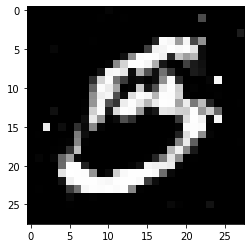

In [30]:
generated_img = generate_from_random_latent_vector(generator_net)
display_image(generated_img)


 
 
<div style="background-color: #ccffcc; padding: 10px;">    

**Now is the time to go back and test the effect of latering those [Learning Rates](#Learning-Rates)**
    
Please feel free to experiment with the network architectures or hyperparameters. You could also try and intentionally cause the generator or discriminator to win and see what happens to the output.

For any questions about using GANs, or how they could be applied to your own research problems please contact Caitlin Howarth at sccmho@leeds.ac.uk.
</div>    

<hr>

<hr>

<div style="background-color: #ccffcc; padding: 10px;">  

# Example Application to Earth Sciences
    
Now that you understand the prinicpals behind GANS, we will use an applied example.    

</div>